In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
# Define the folder structure
base_folder = "./Cube1_2"
channels = ["channel_0", "channel_1"]
sample_length = 2050000  # Number of samples (2.05M)
num_channels = 2

In [4]:
# Count the number of condition folders
condition_folders = [folder for folder in os.listdir(base_folder) if folder.startswith("Cube1_cond")]
N_conditions = len(condition_folders)
N_conditions

23

In [7]:
# Initialize a NumPy array with the shape (N_conditions, 2, 2.05M)
data_array = np.zeros((N_conditions, 2, sample_length))

# Loop through each condition folder
for i, condition_folder in enumerate(sorted(condition_folders, key=lambda x: int(x.split('Cube1_cond')[-1]))):
    # Extract the condition number from the folder name
    condition_number = int(condition_folder.split("Cube1_cond")[-1])
    
    # Loop through each channel
    for j, channel in enumerate(channels):
        # Construct the full path to the channel folder
        channel_folder_path = os.path.join(base_folder, condition_folder, channel)

        # Construct the full path to the CSV file
        file_path = os.path.join(channel_folder_path, f"data_cond{condition_number}.csv")
        
        # Read the CSV file into a DataFrame
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"File {file_path} not found. Skipping this condition.")
            continue

        # Crop the DataFrame
        df_cropped = df.iloc[:sample_length]
        
        # Fill the NumPy array with the cropped data
        # Assuming the data is in the first column of the DataFrame
        data_array[i, j, :] = df_cropped.iloc[:, 0].to_numpy()

print("Data array created with shape:", data_array.shape)

Data array created with shape: (23, 2, 2050000)


In [8]:
folder = './Data'
save_path = os.path.join(folder, "data_array.npy")

# Save the NumPy array to a binary file
np.save(save_path, data_array)

print(f"Database saved to {save_path}")


Database saved to ./Data/data_array.npy


In [9]:
import pandas as pd

# Define the path to the Excel file
excel_path = './Conditions.xlsx'  

# Read the Excel file into a DataFrame
try:
    df_conditions = pd.read_excel(excel_path)
except Exception as e:
    print(f"An error occurred: {e}")
    
df_conditions


,Condition,Power,Speed,Norm Enthalpy,Hatch Spacing
0,1,100,350,43.23,60.20
1,2,100,500,36.17,51.60
2,3,100,800,28.59,41.50
3,4,100,1250,22.87,33.70
4,5,120,500,43.40,56.90
5,6,120,800,34.31,45.90
6,7,120,1100,29.26,39.54
7,8,120,1250,27.45,37.14
8,9,120,1400,25.94,35.14
9,10,160,500,57.87,66.77


In [10]:
def get_condition_info(condition_number, df_conditions):
    """
    Retrieve information for a specific condition number from the DataFrame.

    Parameters:
    - condition_number: int, the condition number
    - df_conditions: pandas DataFrame, the DataFrame containing condition information

    Returns:
    - info_dict: Dictionary containing information for the specified condition
    """
    # Filter the DataFrame to get the row corresponding to the condition number
    condition_row = df_conditions[df_conditions['Condition'] == condition_number]

    # Convert the row to a dictionary
    info_dict = condition_row.iloc[0].to_dict()

    return info_dict

# Example usage:
condition_number = 1
condition_info = get_condition_info(condition_number, df_conditions)
print(f"Information for condition {condition_number}: {condition_info}")


Information for condition 1: {'Condition': 1.0, 'Power': 100.0, 'Speed': 350.0, 'Norm Enthalpy': 43.23, 'Hatch Spacing': 60.2}


In [11]:
def computeBoundaries(signal, th):
    # Identify locations where the signal is greater than the threshold
    locs = np.where(signal > th)[0]

    # Create an array of zeros and assign 1 to the identified locations
    indexes = np.zeros((signal.shape[0], 1))
    indexes[locs] = 1

    # Perform morphological closing and opening operations on the indexes array
    selem = np.ones((70, 1))
    closed = skimage.morphology.closing(indexes, selem)
    opened = skimage.morphology.opening(closed, selem)

    # Identify locations where the opened array has 1's
    locsNew = np.where(opened == 1)[0]

    # Compute the difference between adjacent elements of locsNew
    derNew = np.diff(locsNew)

    # Find indices where the difference is greater than 1
    ind = np.where(derNew > 1)[0]

    # Compute starting and ending indices of the sections
    ending = np.append(locsNew[ind], locsNew[-1])
    starting = np.append(locsNew[0], locsNew[ind + 1])

    return starting, ending

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signals_with_boundaries(dataAllChann, startings, endings):
    # Number of channels and segments
    num_channels, num_segments, _ = dataAllChann.shape

    # Create a single plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Initialize a variable to keep track of the x-axis position
    x_position = 0

    # Loop through each channel and segment to plot them
    for i in range(num_channels):
        for j in range(num_segments):
            # Extract the current segment
            segment = dataAllChann[i, j, :]

            # Generate x values for the current segment
            x_values = np.arange(x_position, x_position + len(segment))

            # Plot the segment
            ax.plot(x_values, segment, label=f'Channel {i}, Segment {j}')

            # Mark the starting and ending points
            ax.scatter(x_values[0], segment[0], color='g')  # Starting point
            ax.scatter(x_values[-1], segment[-1], color='r')  # Ending point

            # Update the x_position for the next segment
            x_position = x_values[-1] + 1

    # Add labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title('Segmented Signals with Start and End Points')

    # Display the plot
    plt.show()


In [13]:
num_signals = 5
# Generate num_signals random integers between 0 and N_conditions
random_conditions = np.random.randint(0, N_conditions, num_signals)
random_conditions

array([20, 15,  1, 15,  0])

<IPython.core.display.Javascript object>


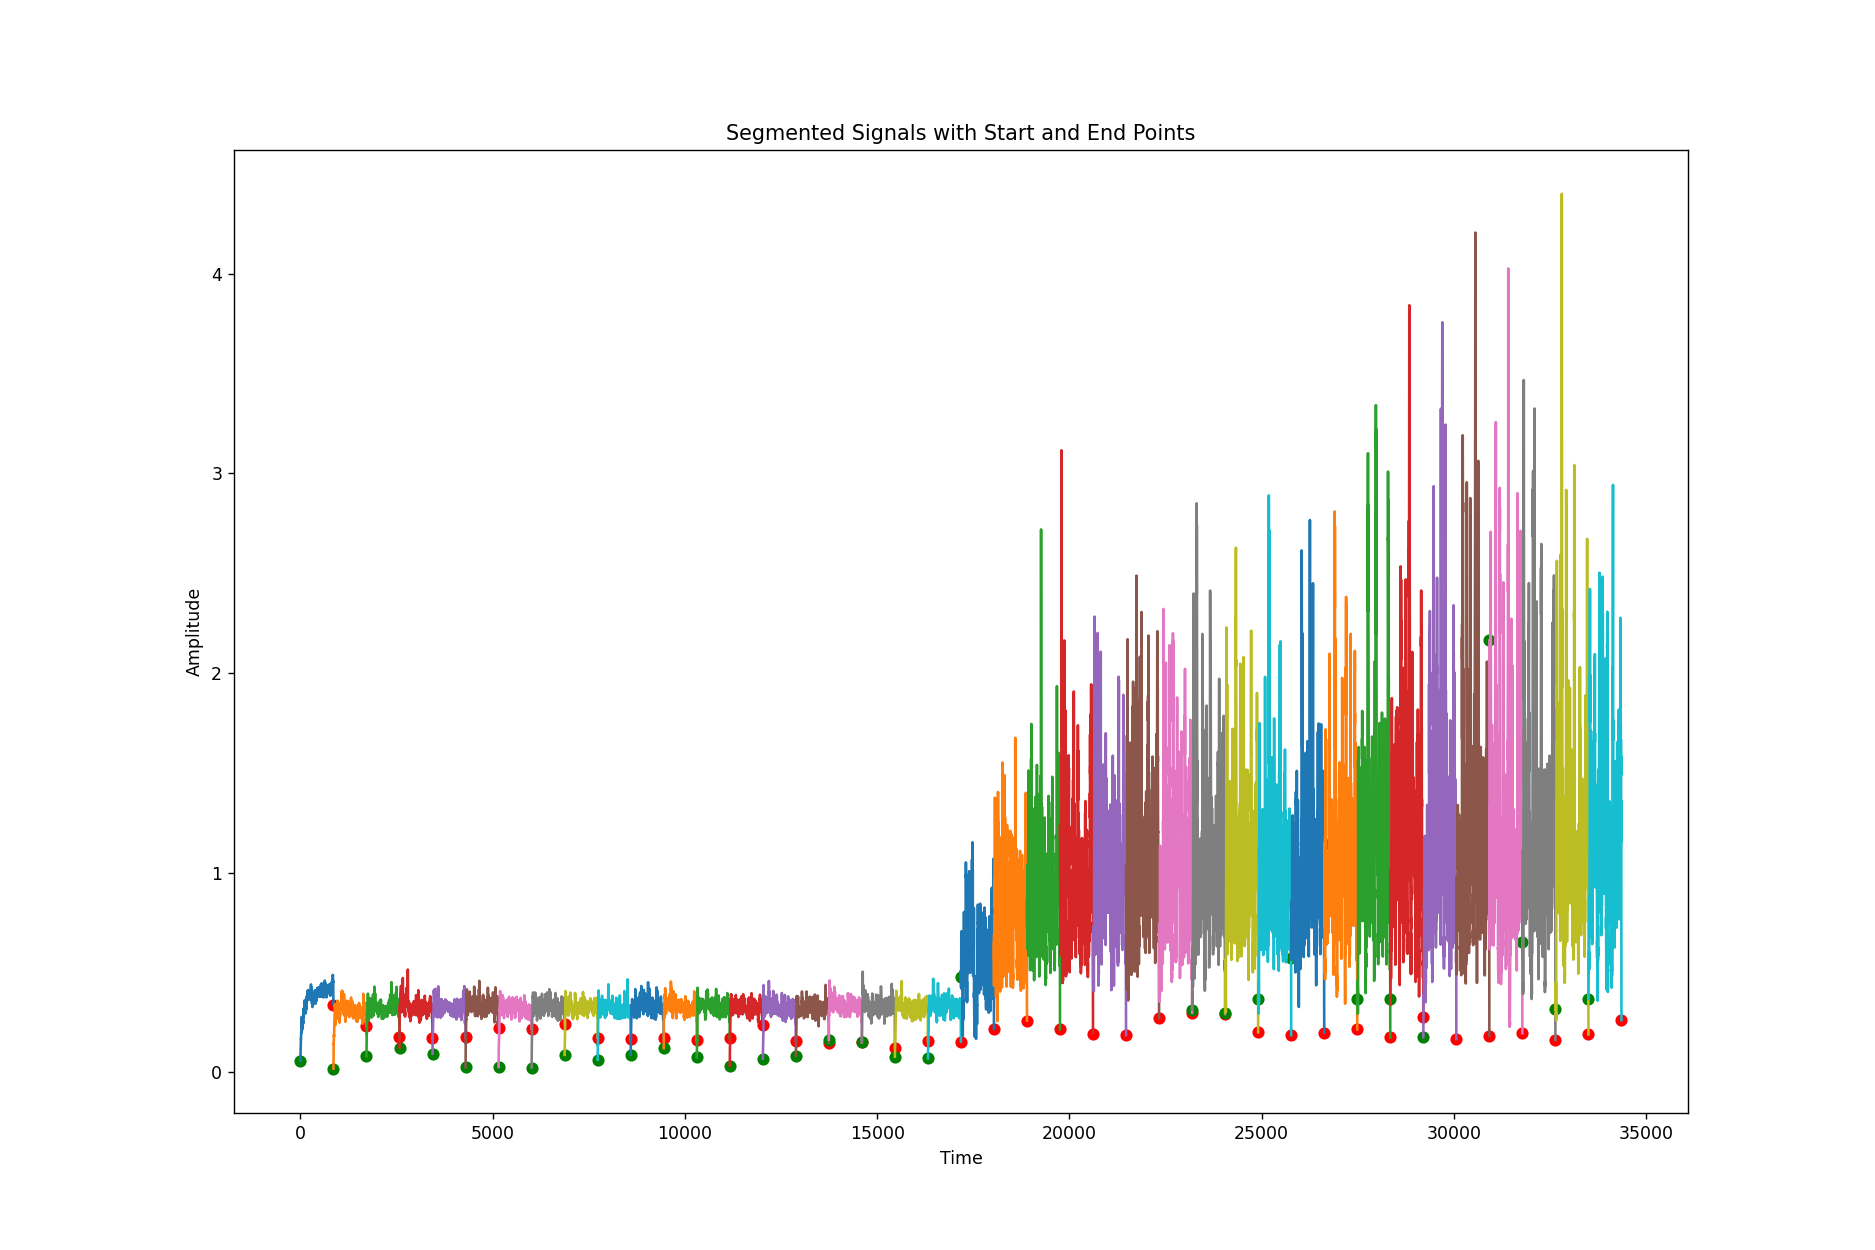

<IPython.core.display.Javascript object>


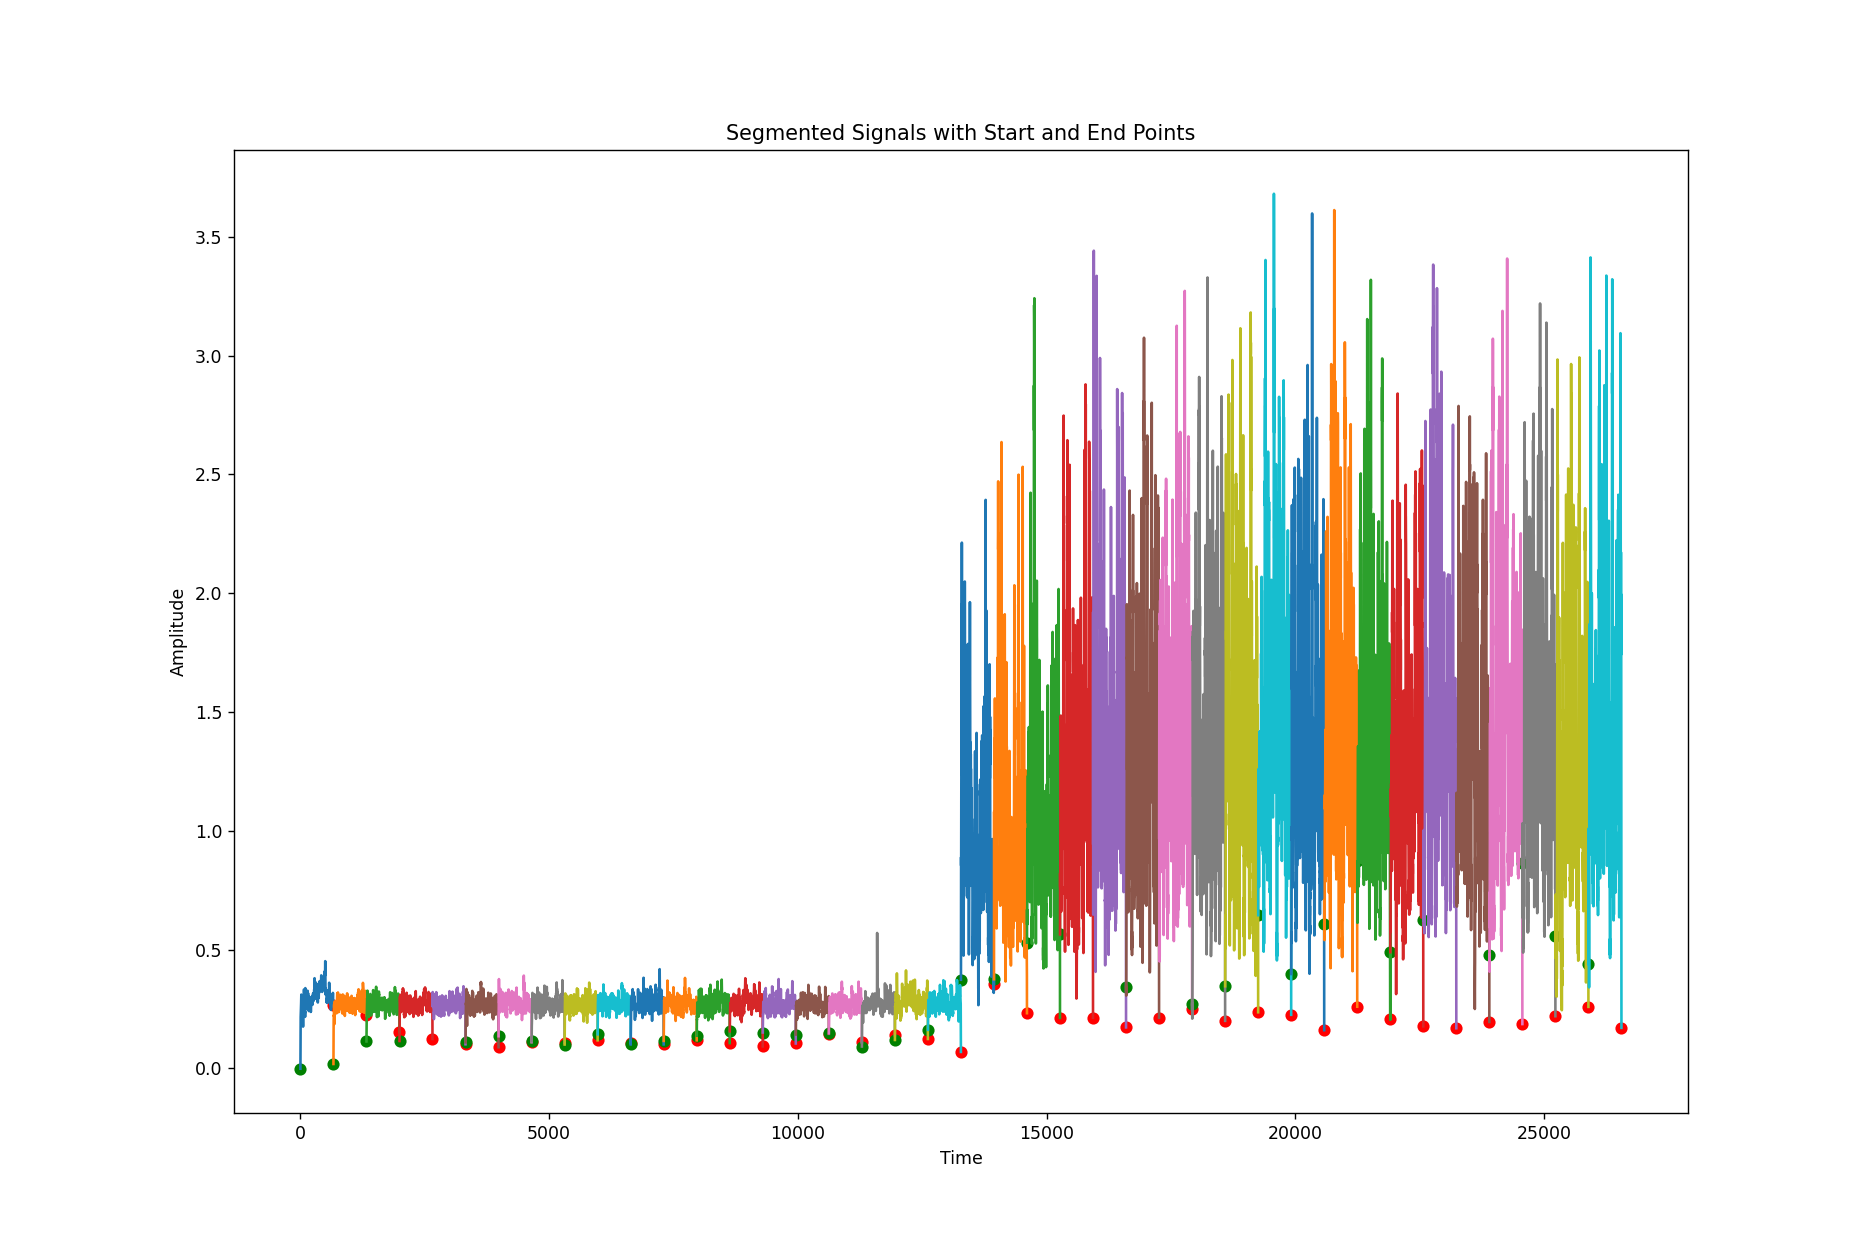

<IPython.core.display.Javascript object>


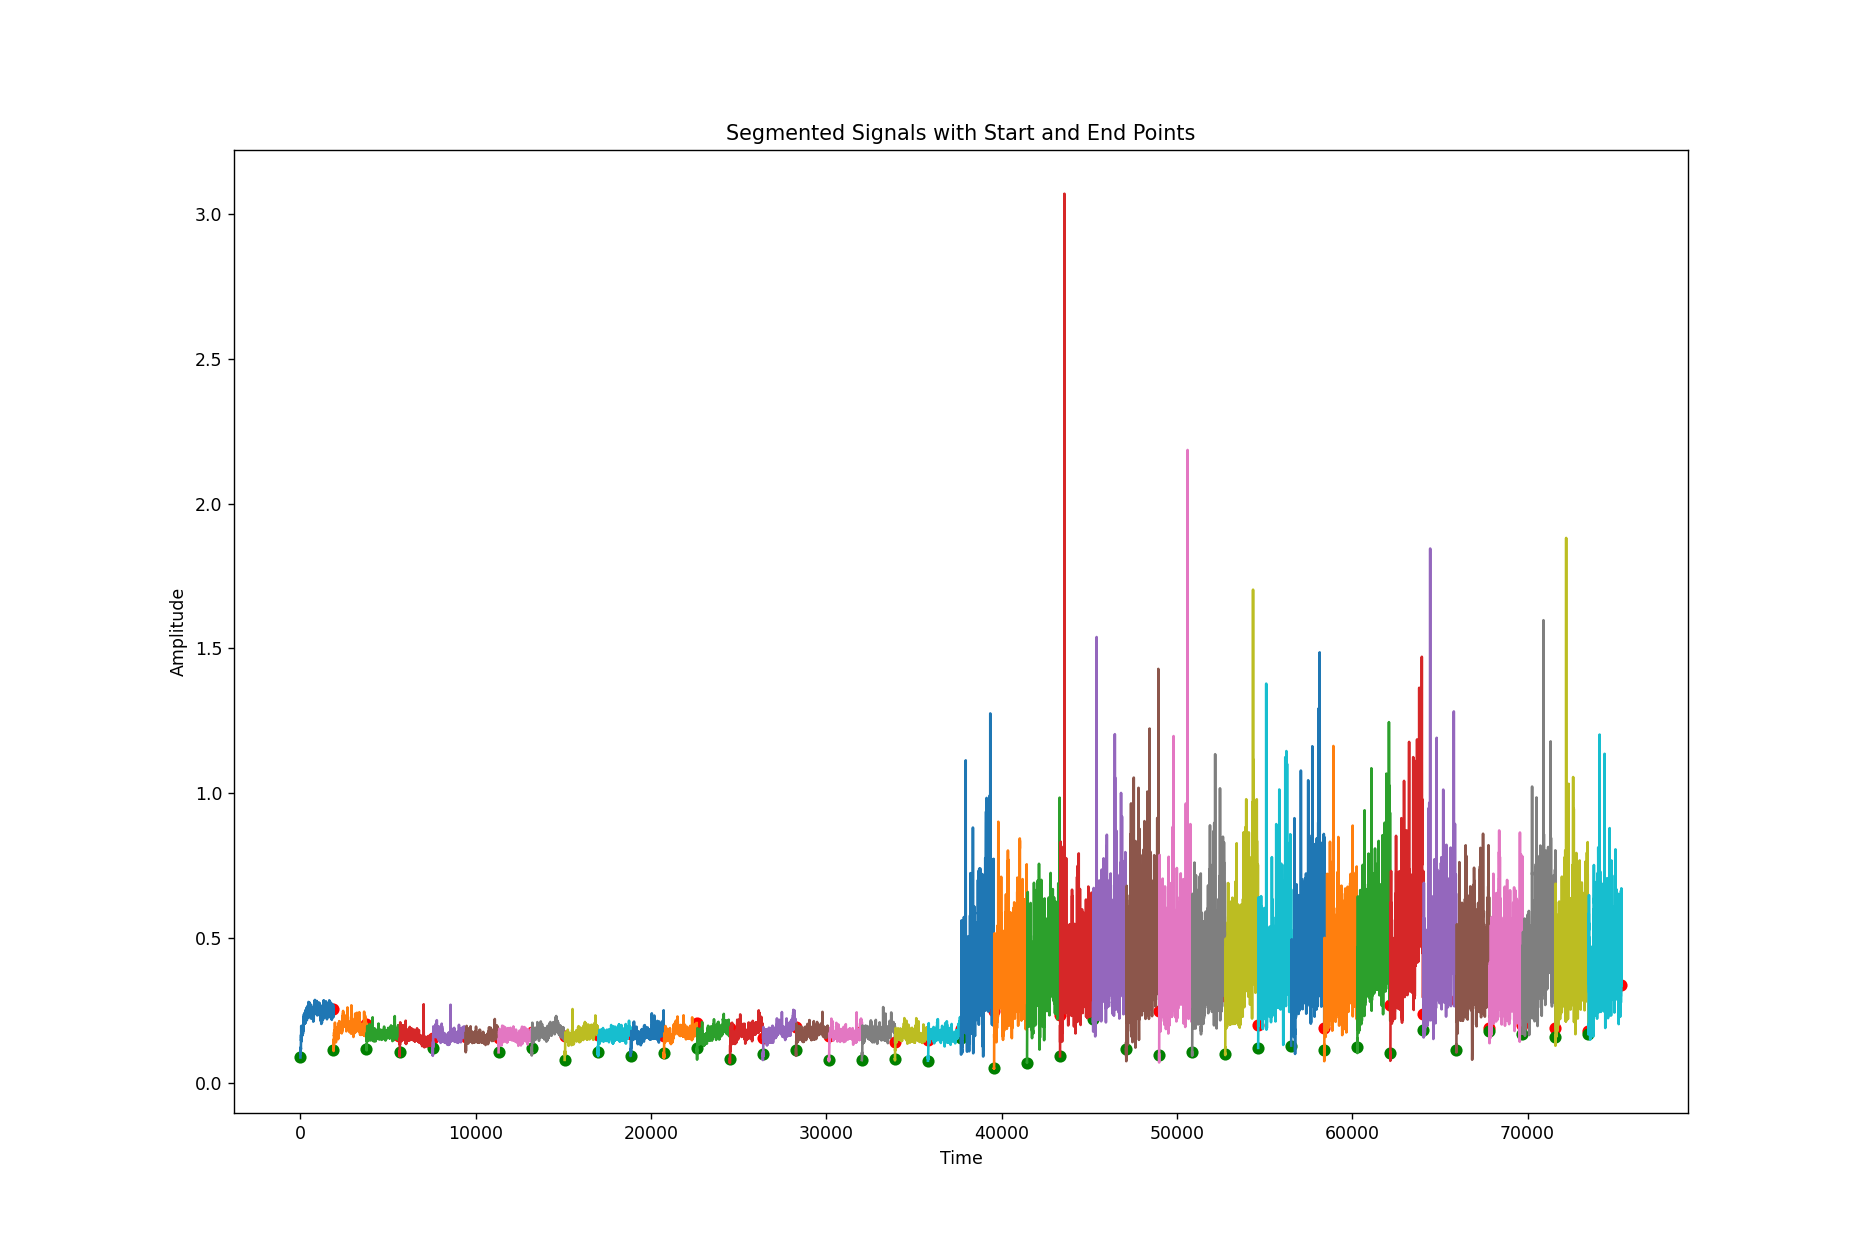

<IPython.core.display.Javascript object>


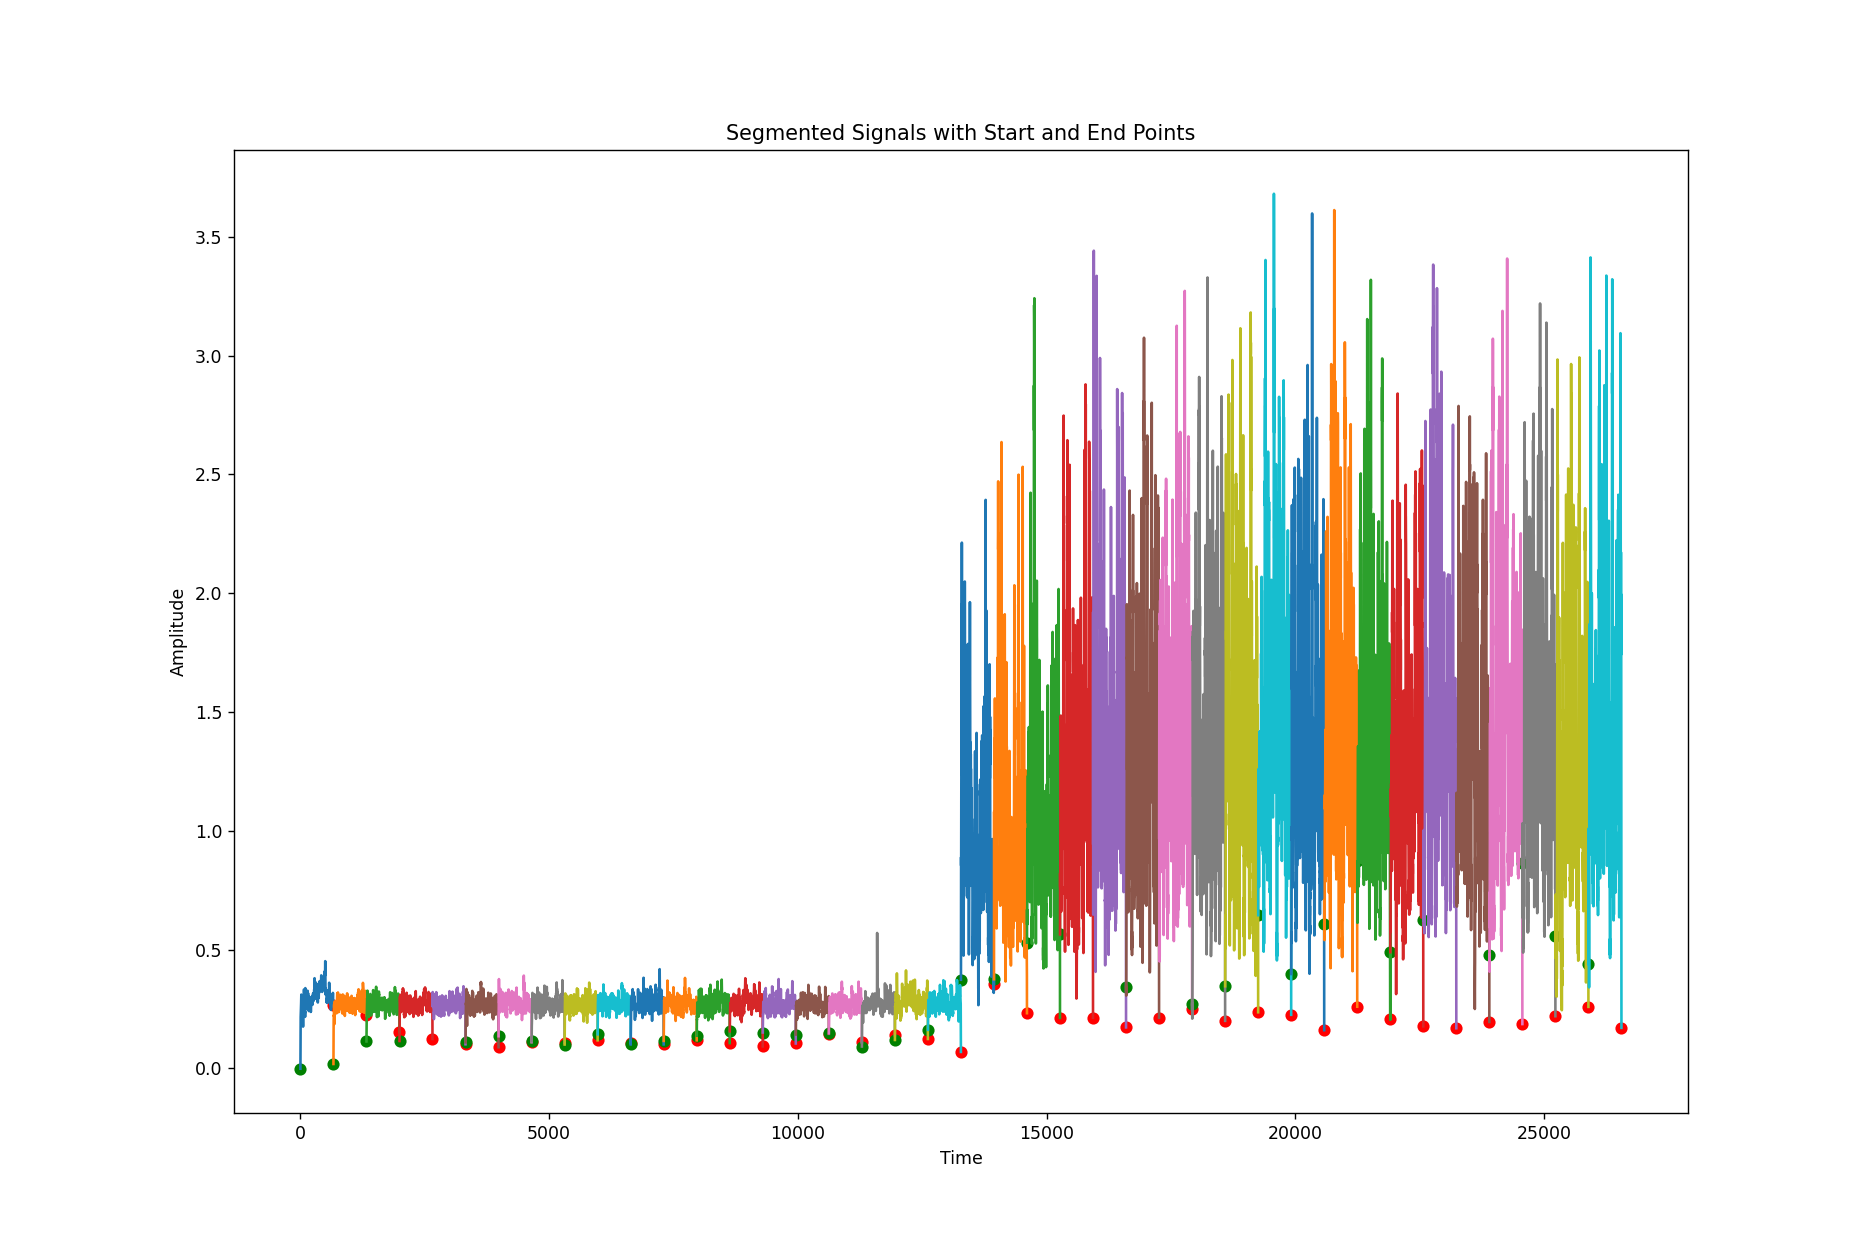

<IPython.core.display.Javascript object>


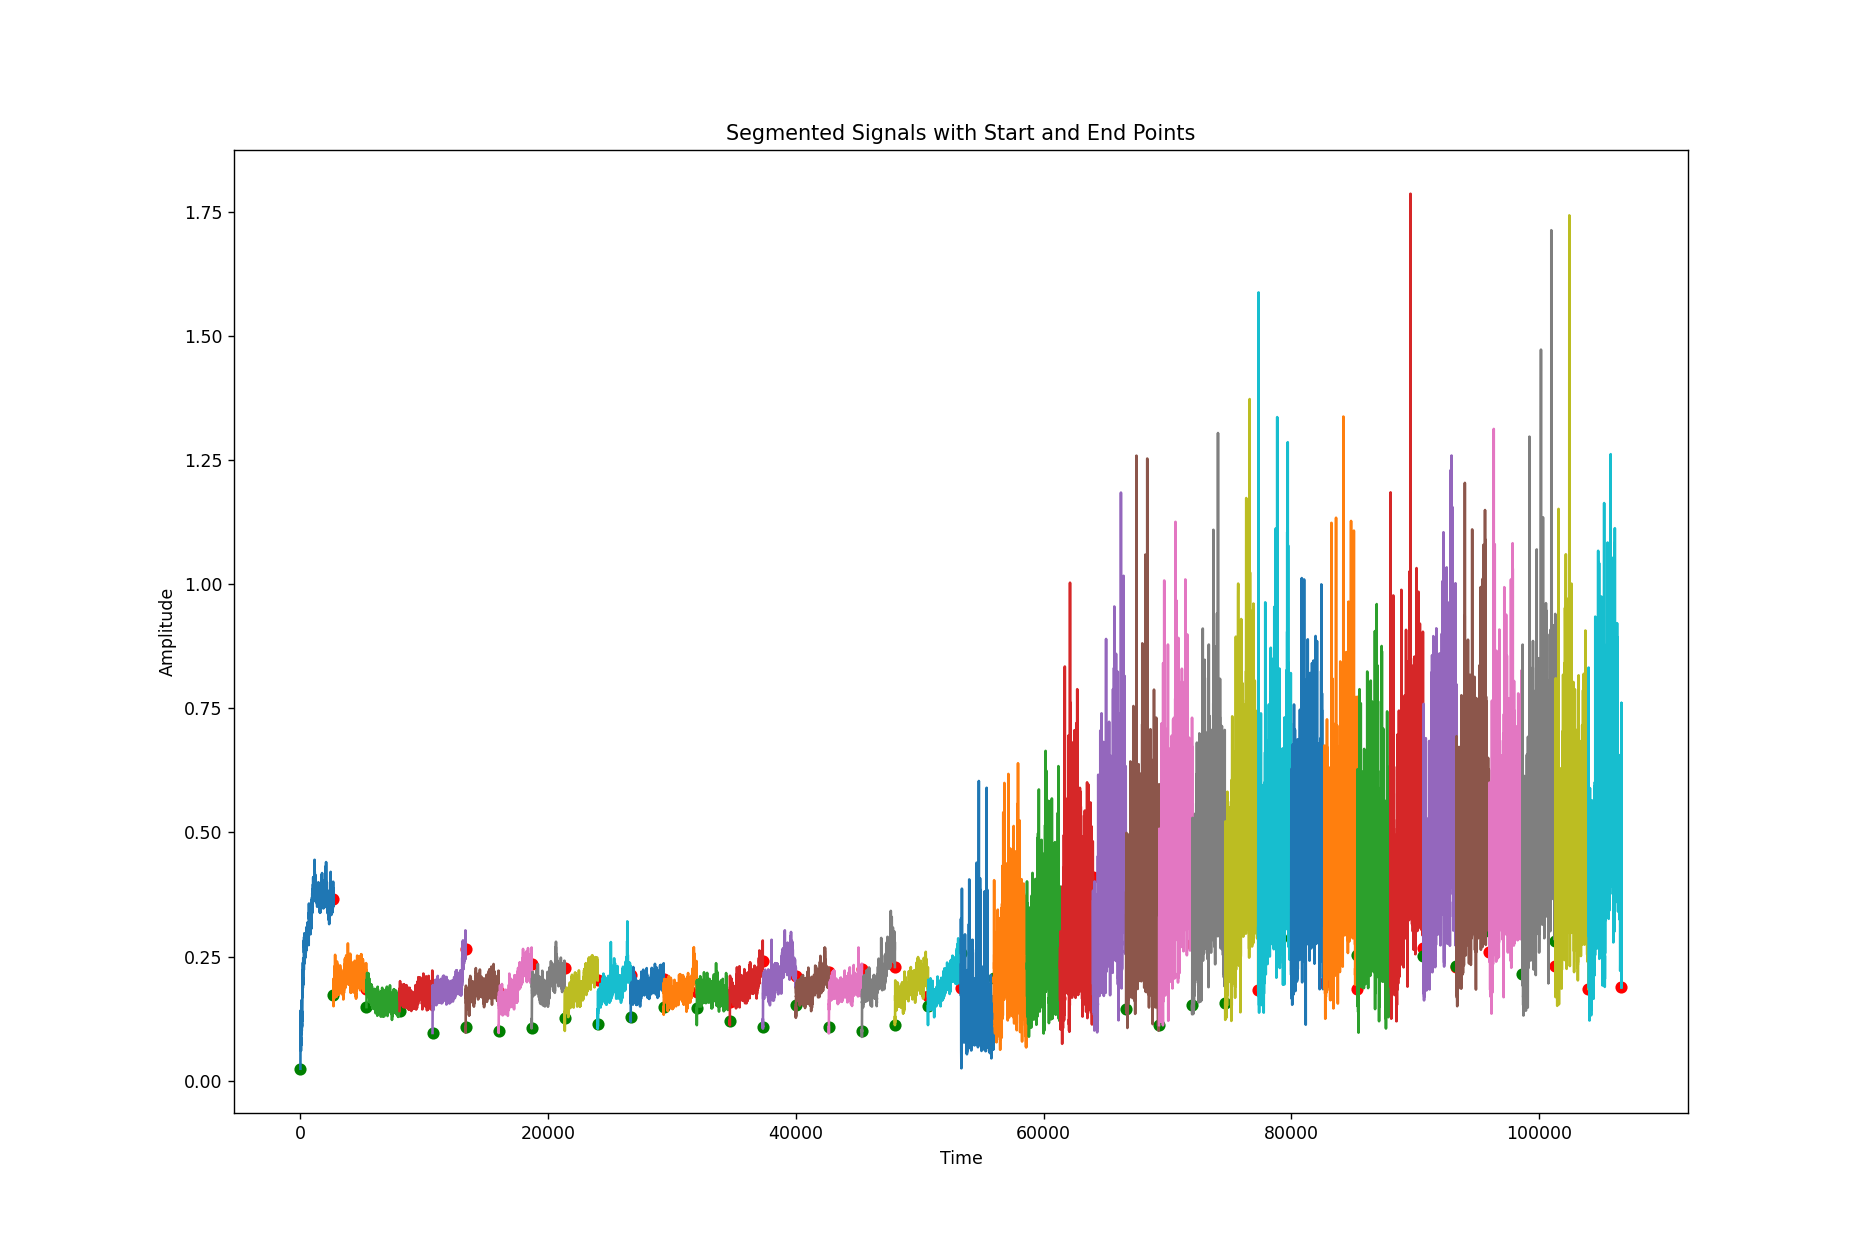

In [14]:
import skimage.morphology

# Threshold value for computeBoundaries
th = 0.1  

# Loop through the random conditions
for condition in random_conditions:
    # Extract corresponding data for each channel
    data_channel_0 = data_array[condition, 0, :]
    data_channel_1 = data_array[condition, 1, :]

    # Find the boundaries using computeBoundaries() based on channel_1 data
    starting_1, ending_1 = computeBoundaries(data_channel_1, th)
    
    # Compute size of the segments
    size_segments = ending_1 - starting_1
    
    # Get the minimum size
    min_size = min(size_segments)

    # Use these boundaries to segment both channels
    segmented_0 = [data_channel_0[end-min_size:end] for end in ending_1]
    segmented_1 = [data_channel_1[end-min_size:end] for end in ending_1]
    
    # Convert to NumPy array with the desired shape
    n_segments = len(segmented_0)  
    dataAllChann = np.zeros((2, n_segments, min_size))

    for i, segment in enumerate(segmented_0):
        dataAllChann[0, i, :] = segment[:min_size]

    for i, segment in enumerate(segmented_1):
        dataAllChann[1, i, :] = segment[:min_size]
    
    plot_signals_with_boundaries(dataAllChann, starting_1, ending_1)

In [15]:
def plot_signals_with_boundaries(data_channel_0, data_channel_1, startings, endings):
    # Create a figure with two subplots (one for each channel)
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))

    # Plot the data for channel_0
    axs[0].plot(data_channel_0, label='Channel 0')
    axs[0].scatter(startings, data_channel_0[startings], color='g', label='Starting points')
    axs[0].scatter(endings, data_channel_0[endings], color='r', label='Ending points')
    axs[0].legend()
    axs[0].set_title('Channel 0')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Amplitude')

    # Plot the data for channel_1
    axs[1].plot(data_channel_1, label='Channel 1')
    axs[1].scatter(startings, data_channel_1[startings], color='g', label='Starting points')
    axs[1].scatter(endings, data_channel_1[endings], color='r', label='Ending points')
    axs[1].legend()
    axs[1].set_title('Channel 1')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Amplitude')

    # Show the plot
    plt.tight_layout()
    plt.show()


<IPython.core.display.Javascript object>


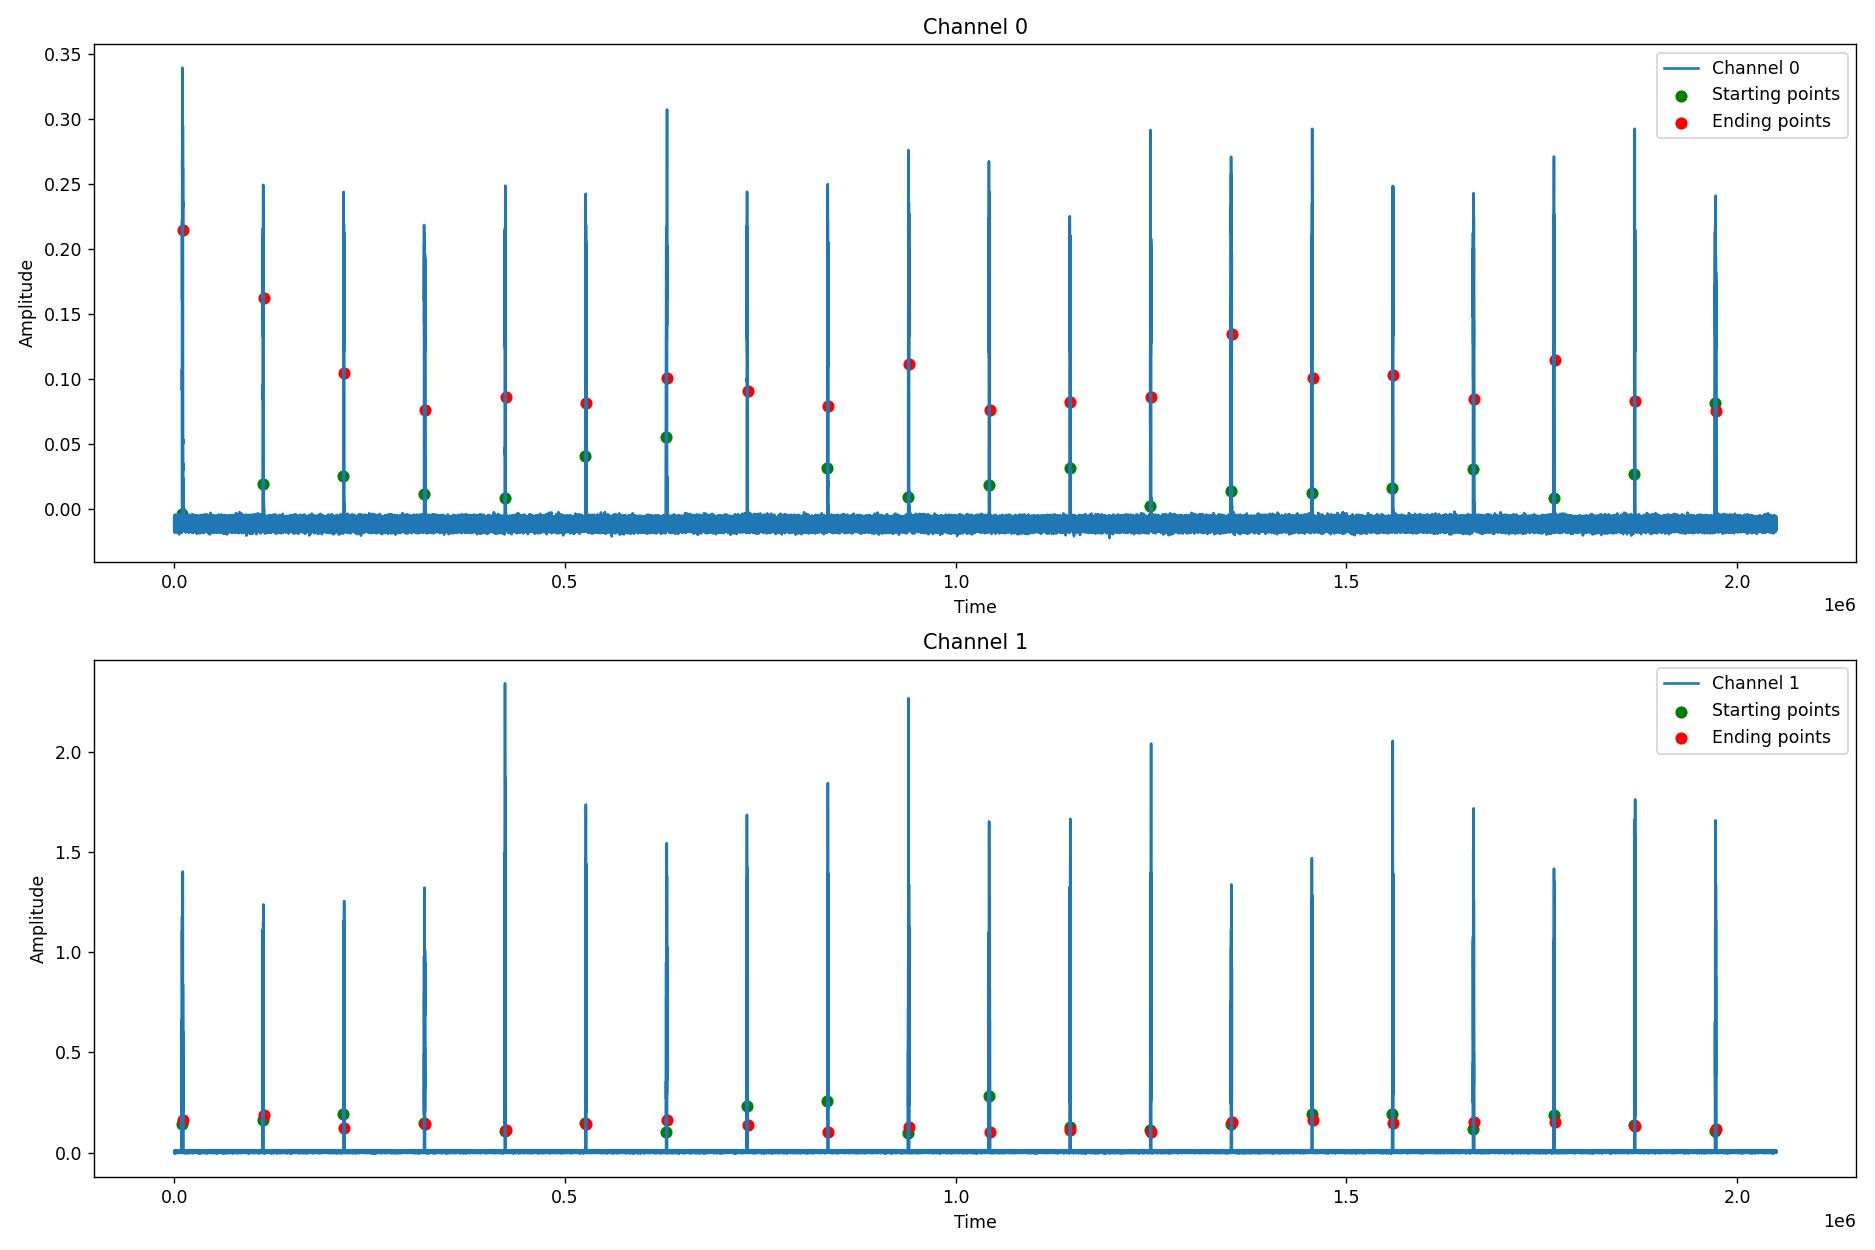

<IPython.core.display.Javascript object>


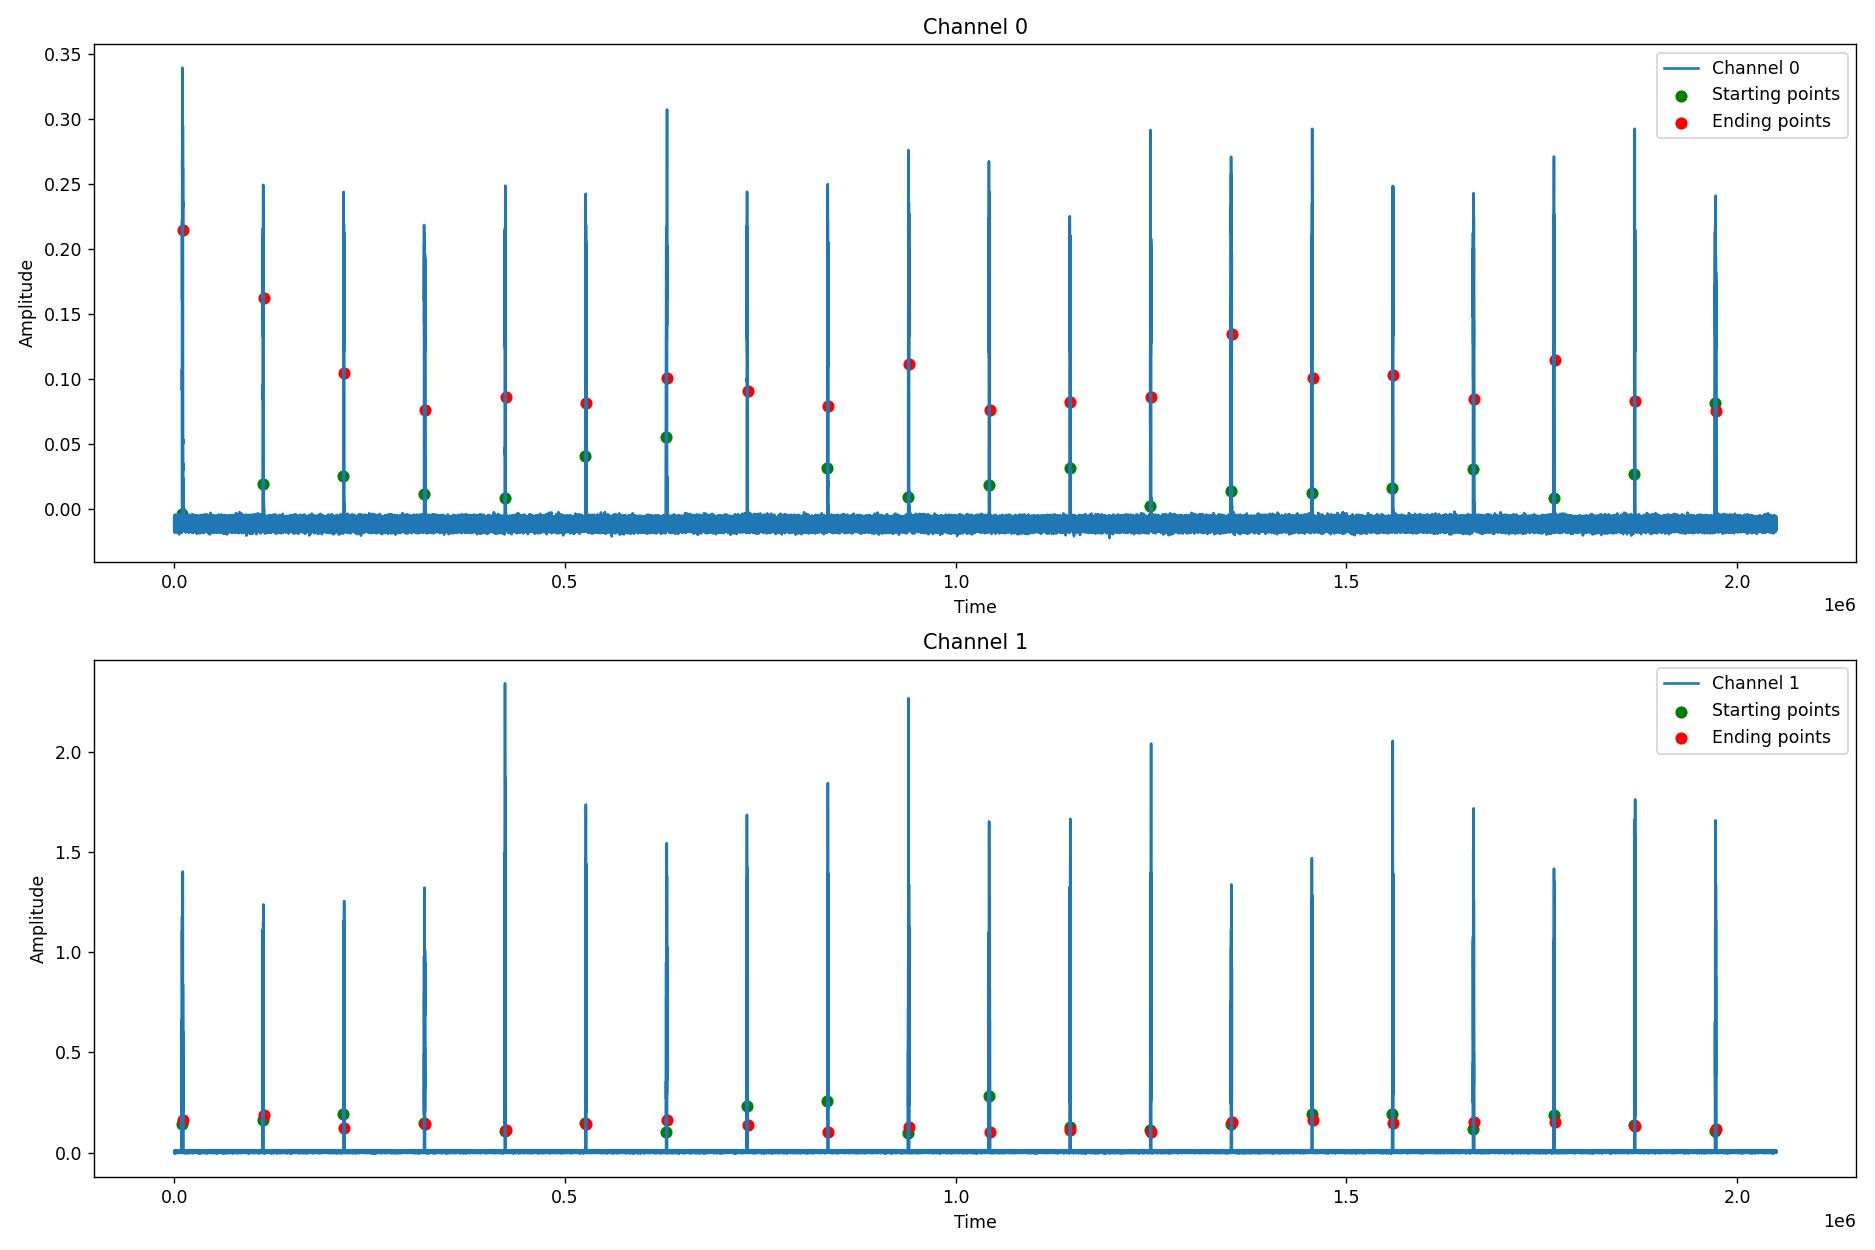

<IPython.core.display.Javascript object>


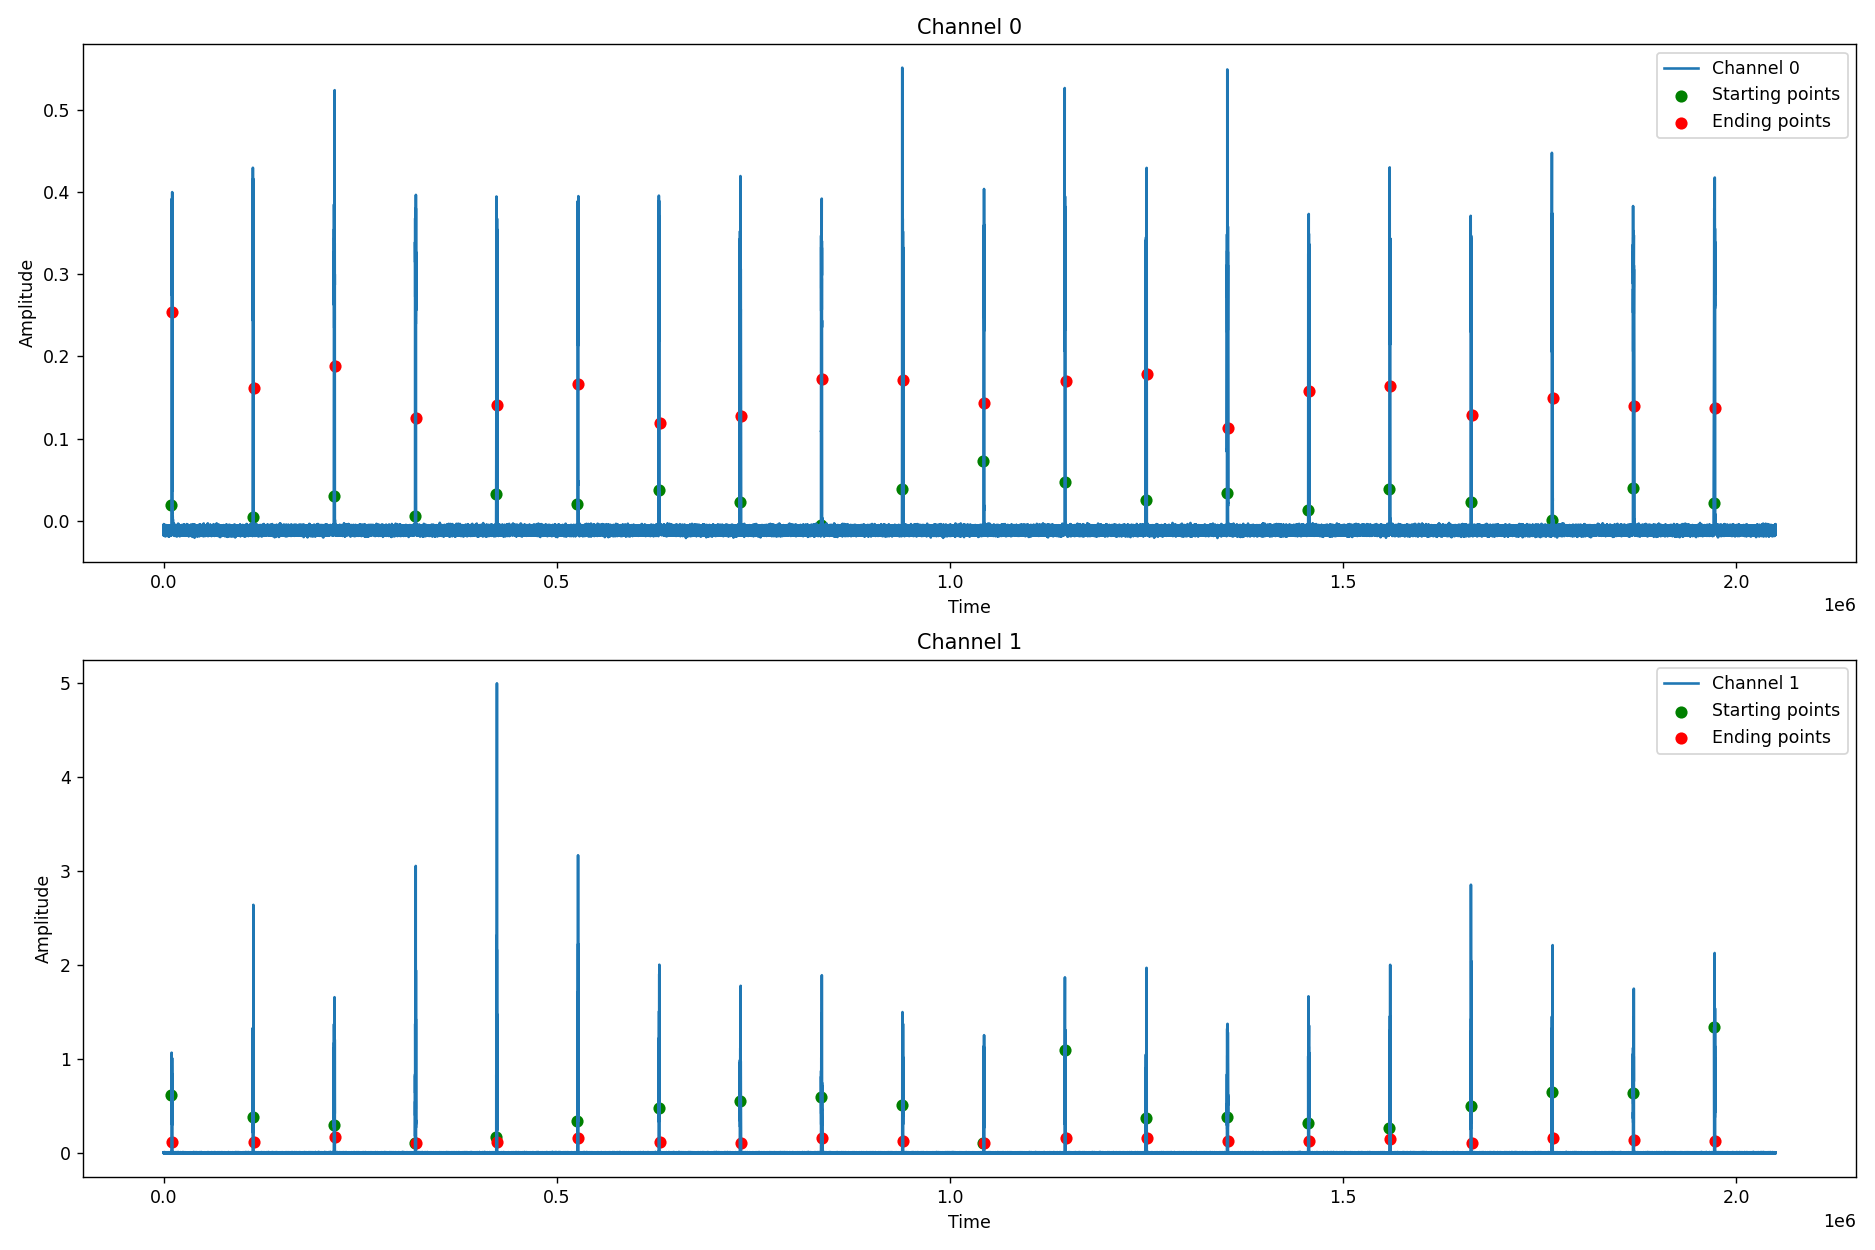

<IPython.core.display.Javascript object>


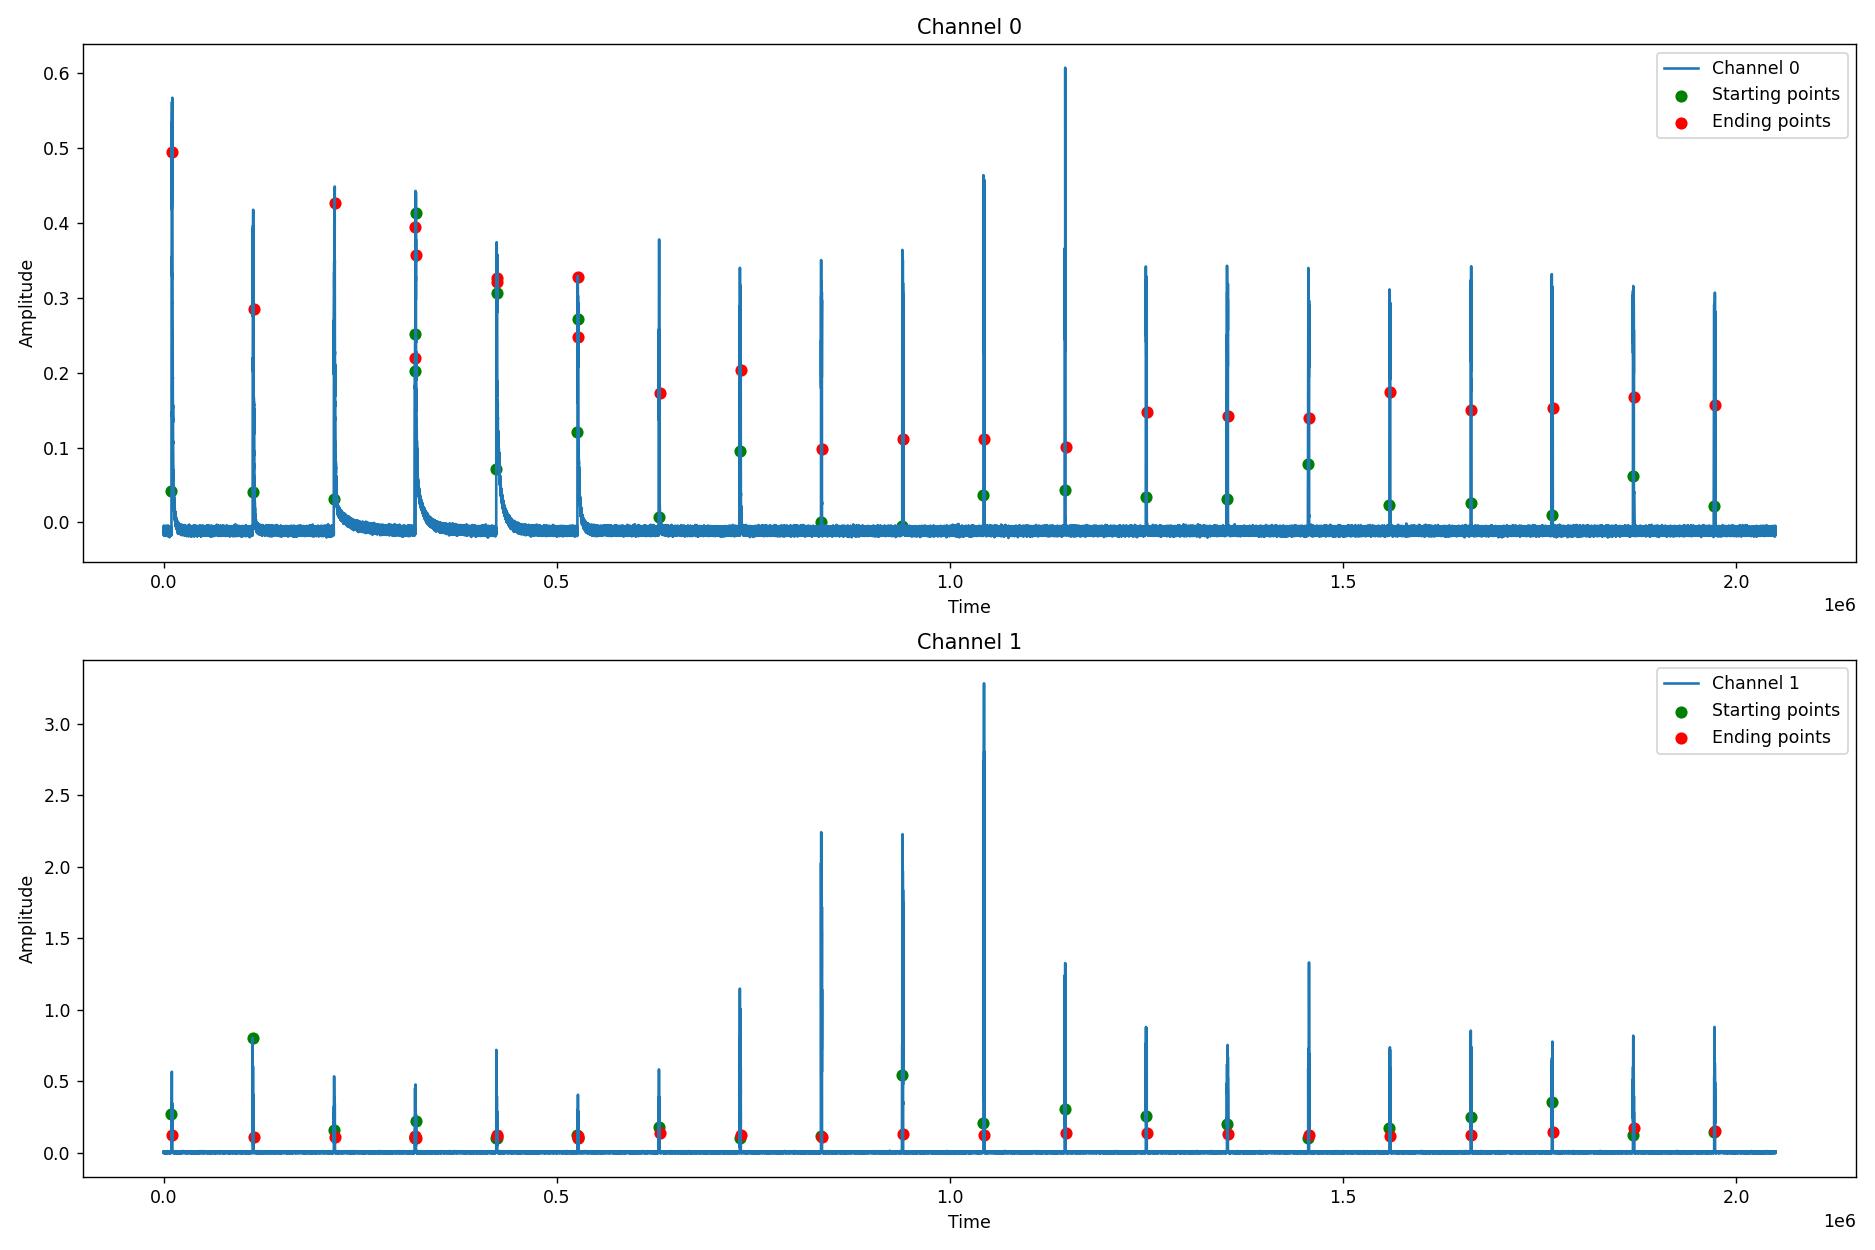

<IPython.core.display.Javascript object>


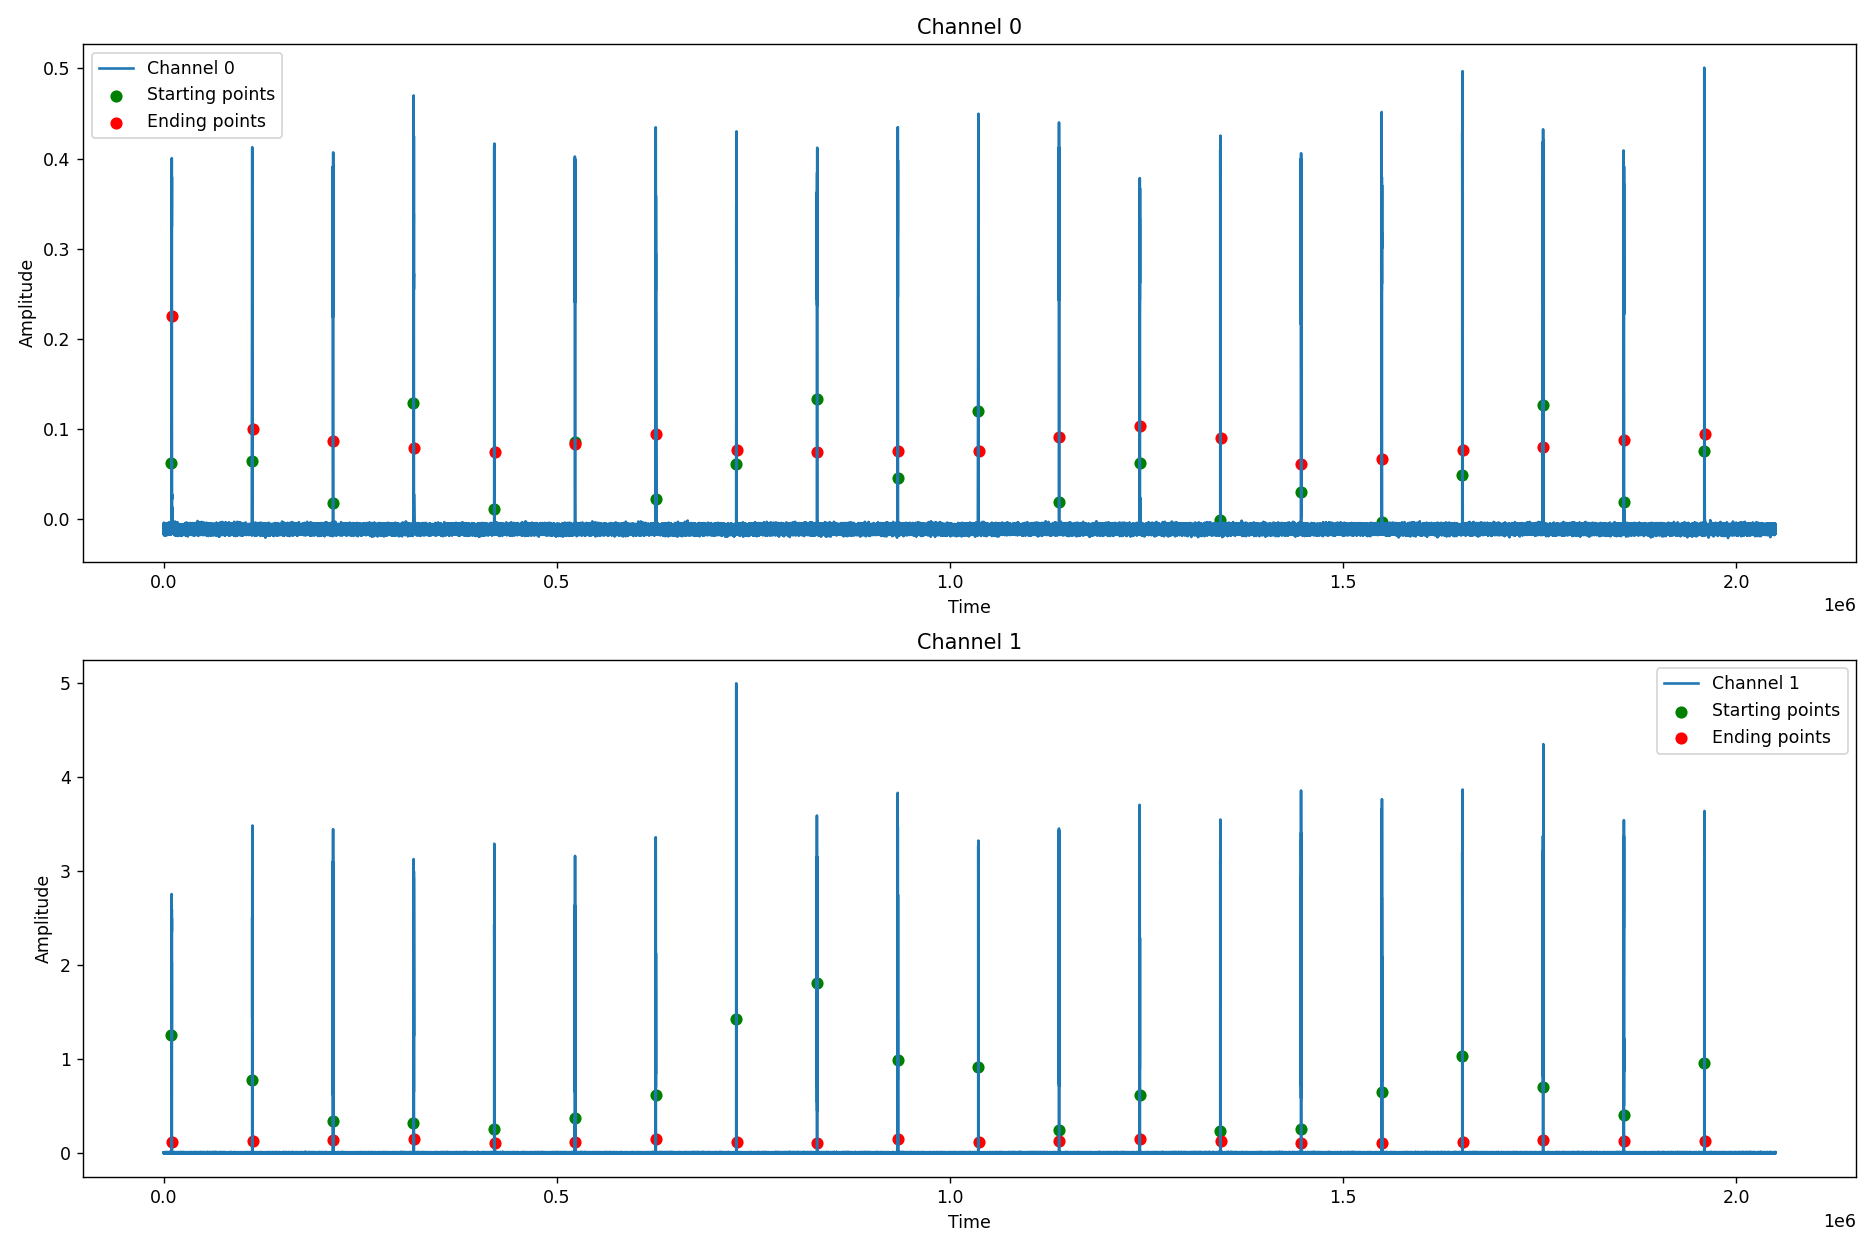

In [16]:
# Threshold value for computeBoundaries
th = 0.1  

# Generate 5 random integers between 0 and N_conditions
N_conditions = data_array.shape[0]  
random_conditions = np.random.randint(0, N_conditions, 5)

# Loop through the random conditions
for condition in random_conditions:
    # Extract corresponding data for each channel
    data_channel_0 = data_array[condition, 0, :]
    data_channel_1 = data_array[condition, 1, :]

    # Find the boundaries using computeBoundaries() based on channel_1 data
    starting_1, ending_1 = computeBoundaries(data_channel_1, th)

    # Plot the full-length signals along with the starting and ending points
    plot_signals_with_boundaries(data_channel_0, data_channel_1, starting_1, ending_1)

<IPython.core.display.Javascript object>


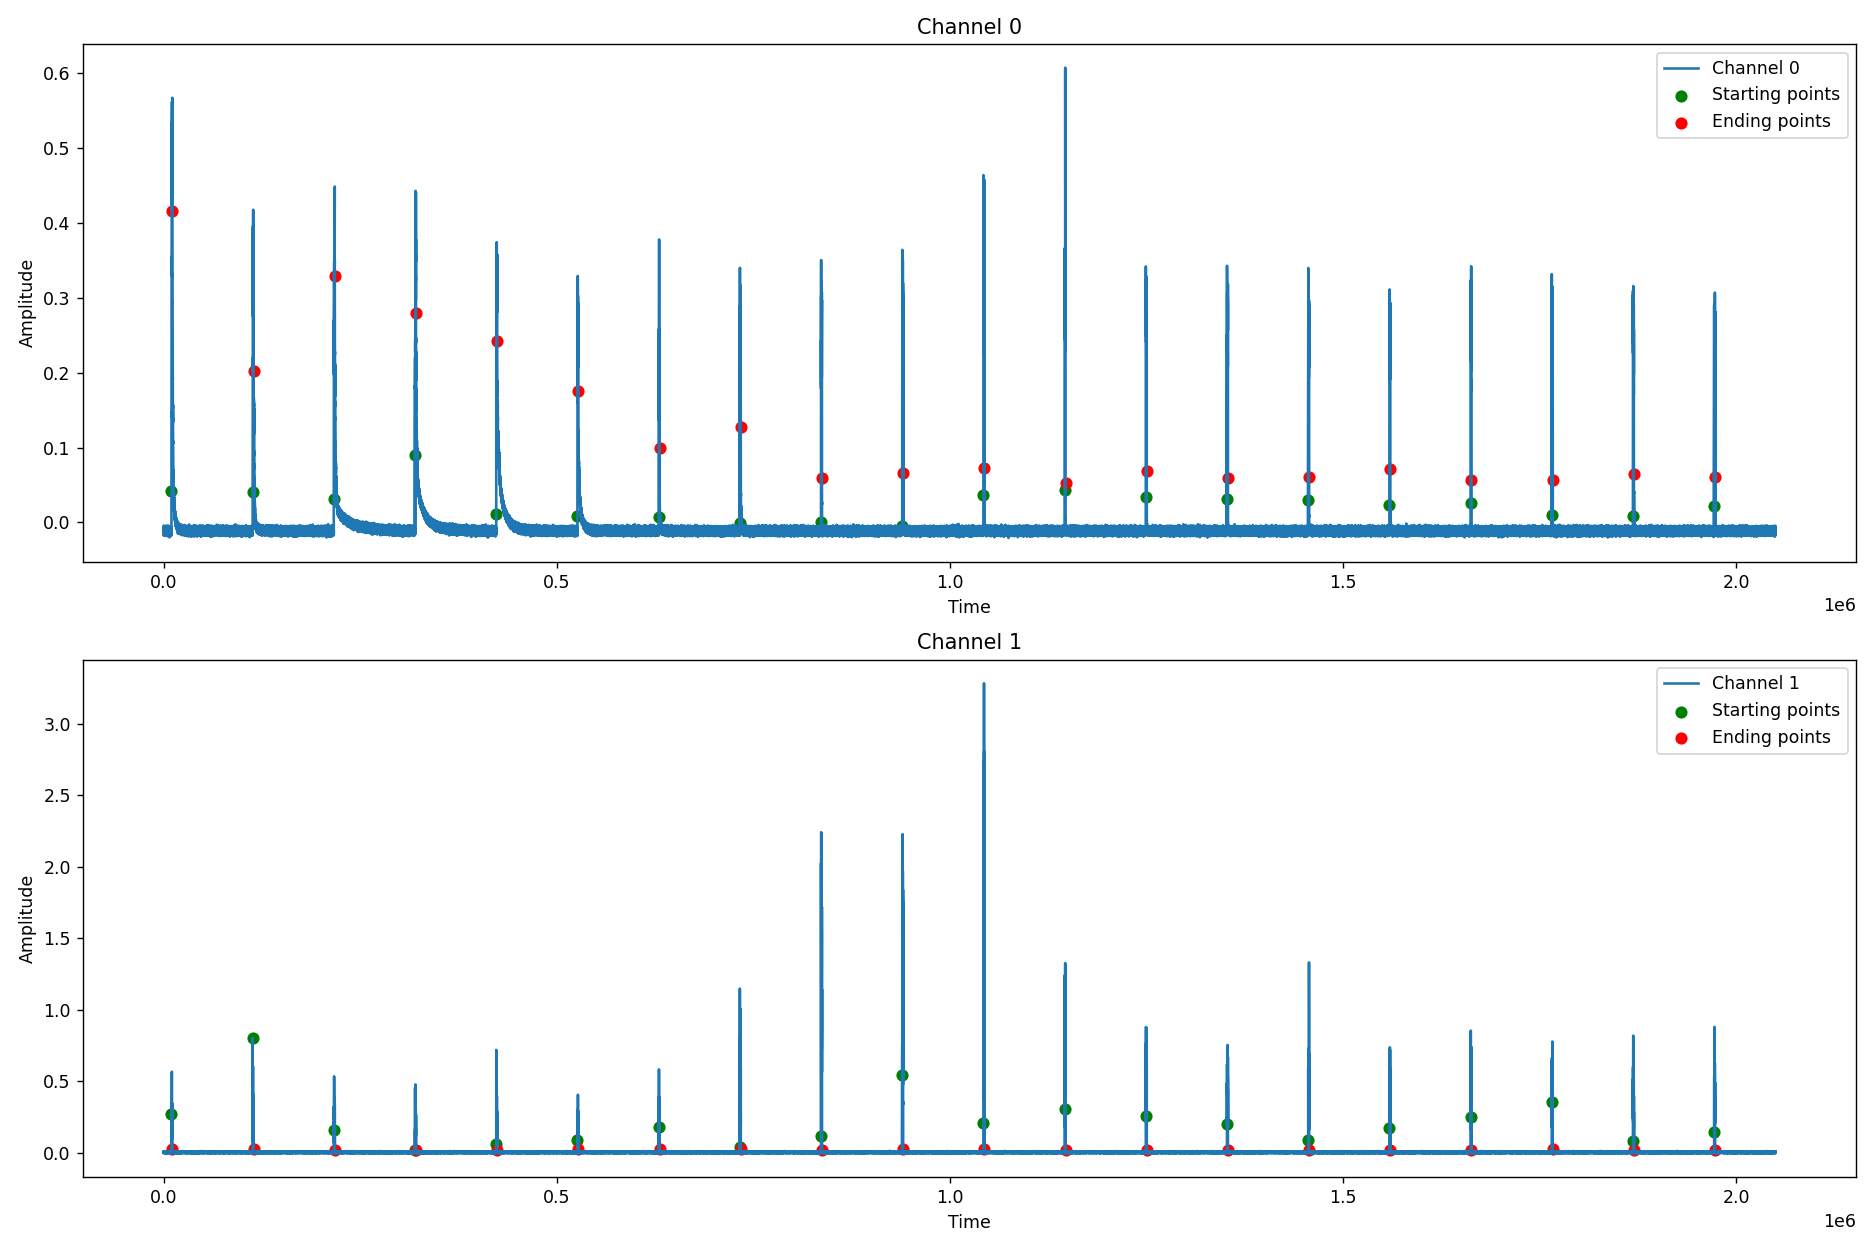

In [17]:
# Threshold value for computeBoundaries
th = 0.02 

# Ask for the condition number to plot
condition_to_plot = 13

# Check if the entered condition number is valid
if 0 <= condition_to_plot < N_conditions:
    # Extract corresponding data for each channel
    data_channel_0 = data_array[condition_to_plot, 0, :]
    data_channel_1 = data_array[condition_to_plot, 1, :]

    # Find the boundaries using computeBoundaries() based on channel_1 data
    starting_1, ending_1 = computeBoundaries(data_channel_1, th)

    # Plot the full-length signals along with the starting and ending points
    plot_signals_with_boundaries(data_channel_0, data_channel_1, starting_1, ending_1)
else:
    print("Invalid condition number. Please enter a number between 0 and {}.".format(N_conditions - 1))


In [18]:
# Initialize an empty list to collect segmented data for each condition
final_data_list = []

# Loop through all conditions
for condition in range(N_conditions):
    # Extract corresponding data for each channel
    data_channel_0 = data_array[condition, 0, :]
    data_channel_1 = data_array[condition, 1, :]

    # Compute boundaries using computeBoundaries() based on channel_1 data
    starting_1, ending_1 = computeBoundaries(data_channel_1, th)

    # Compute size of the segments
    size_segments = ending_1 - starting_1
    
    # Get the minimum size for this condition
    min_size = min(size_segments)

    # Check that each condition has exactly 20 segments
    n_segments = len(starting_1)
    if n_segments != 20:
        print(f"Condition {condition} does not have exactly 20 segments. It has {n_segments} segments.")
        continue

    # Segment both channels using these boundaries and minimum size
    segmented_0 = np.array([data_channel_0[end-min_size:end] for end in ending_1])
    segmented_1 = np.array([data_channel_1[end-min_size:end] for end in ending_1])

    # Combine the segmented data for both channels into one array
    condition_data = np.stack([segmented_0, segmented_1])

    # Append this condition data to the list
    final_data_list.append(condition_data)


In [19]:
# Loop through final_data_list to print the dimensions of each array
for i, condition_data in enumerate(final_data_list):
    print(f"Dimensions of array for Condition {i}: {condition_data.shape}")


Dimensions of array for Condition 0: (2, 20, 2807)
Dimensions of array for Condition 1: (2, 20, 1945)
Dimensions of array for Condition 2: (2, 20, 1201)
Dimensions of array for Condition 3: (2, 20, 753)
Dimensions of array for Condition 4: (2, 20, 1952)
Dimensions of array for Condition 5: (2, 20, 1202)
Dimensions of array for Condition 6: (2, 20, 862)
Dimensions of array for Condition 7: (2, 20, 754)
Dimensions of array for Condition 8: (2, 20, 668)
Dimensions of array for Condition 9: (2, 20, 1952)
Dimensions of array for Condition 10: (2, 20, 1202)
Dimensions of array for Condition 11: (2, 20, 862)
Dimensions of array for Condition 12: (2, 20, 668)
Dimensions of array for Condition 13: (2, 20, 1184)
Dimensions of array for Condition 14: (2, 20, 861)
Dimensions of array for Condition 15: (2, 20, 668)
Dimensions of array for Condition 16: (2, 20, 542)
Dimensions of array for Condition 17: (2, 20, 495)
Dimensions of array for Condition 18: (2, 20, 455)
Dimensions of array for Condition

In [20]:
import pickle

# Specify the filename
filename = './Data/final_data_list.pkl'

# Open the file in write-binary mode and save final_data_list
with open(filename, 'wb') as f:
    pickle.dump(final_data_list, f)

print(f"final_data_list has been saved to {filename}")


final_data_list has been saved to ./Data/final_data_list.pkl
